**OUR GOAL**

- Predict various protein structures in cellular images
- there are 28 different target proteins
- multiple proteins can be present in one image (multilabel classification)

In [1]:
class KernelSettings:
    
    def __init__(self, fit_baseline=False, fit_improved_baseline=False):
        self.fit_baseline = fit_baseline
        self.fit_improved_baseline = fit_improved_baseline

In [2]:
kernelsettings = KernelSettings(fit_baseline=False, fit_improved_baseline=True)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

['train', 'test', 'train.csv', 'sample_submission.csv']


In [4]:
train_labels = pd.read_csv("../input/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [5]:
train_labels.shape[0]

31072

In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [7]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [8]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


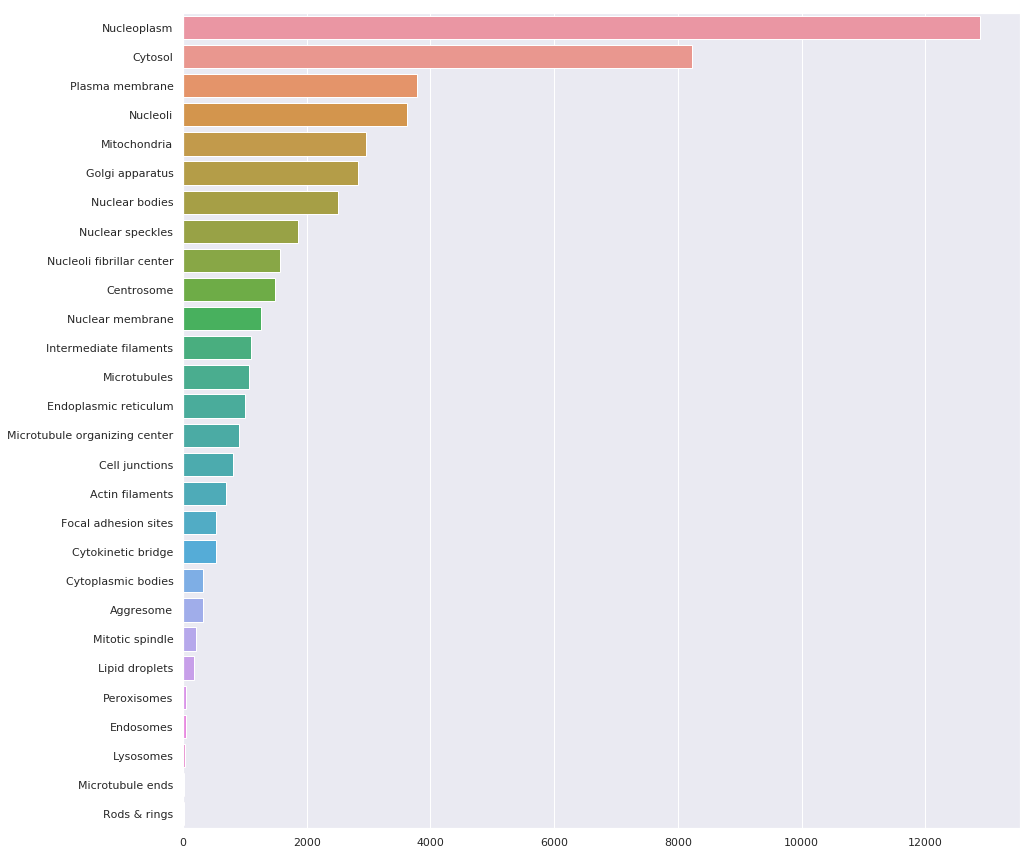

In [9]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Text(0,0.5,'% of data')

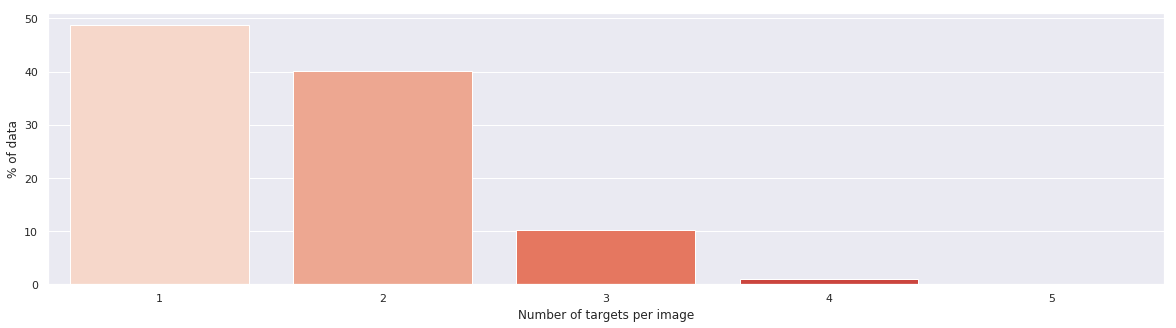

In [10]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

**Coorelation between targets**

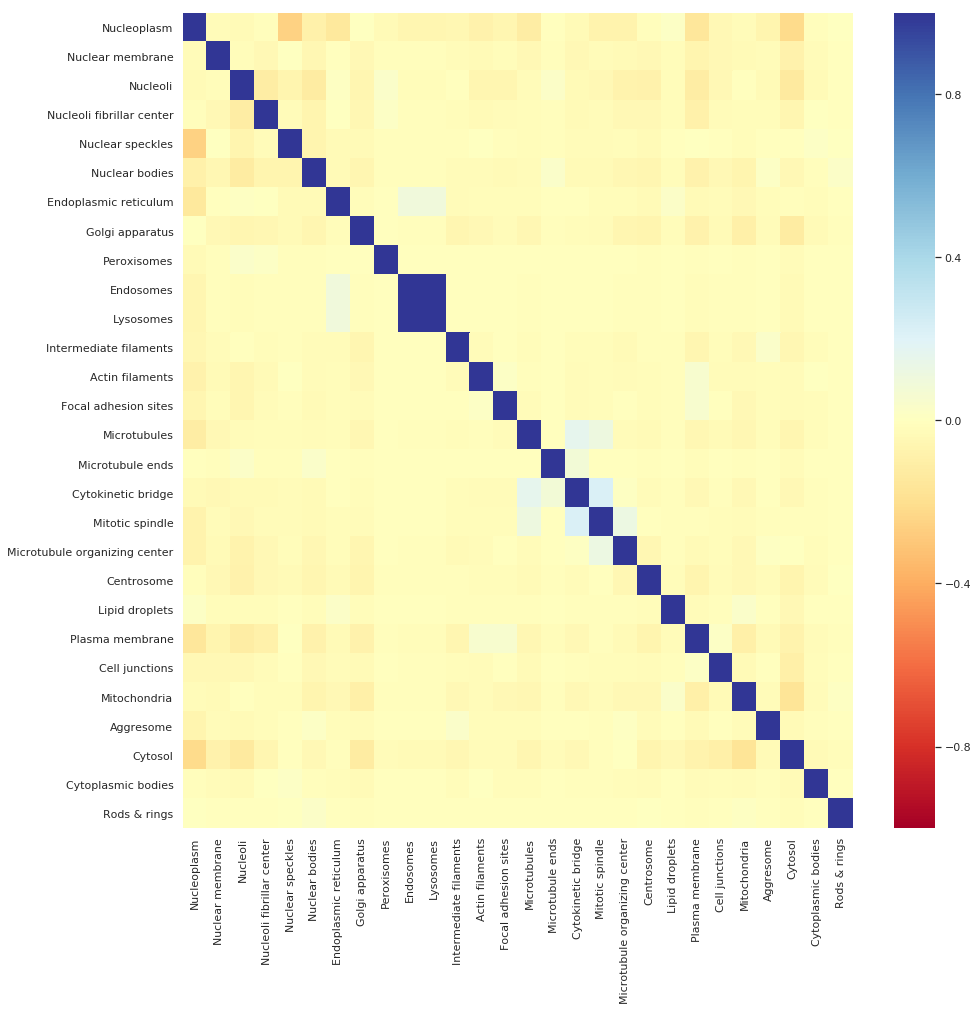

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

**OBSERVING HOW THEY ARE GROUPED**

**Lysosomes and endosomes**

In [12]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

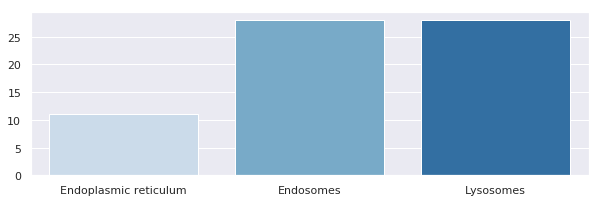

In [13]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

**Rods and rings**

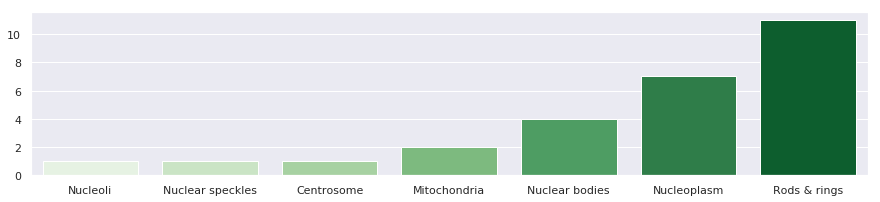

In [14]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

**Peroxisomes**

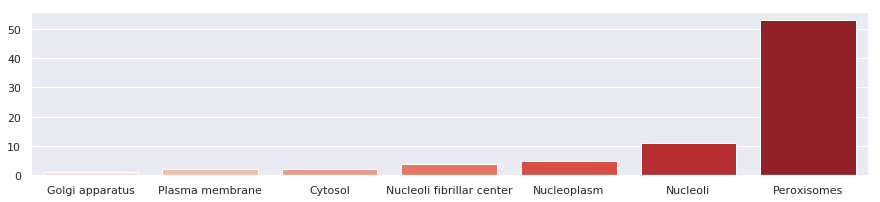

In [15]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

**Microtubule ends**

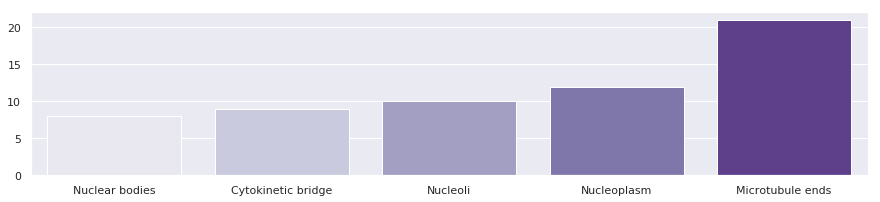

In [16]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

**Nuclear speckles**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

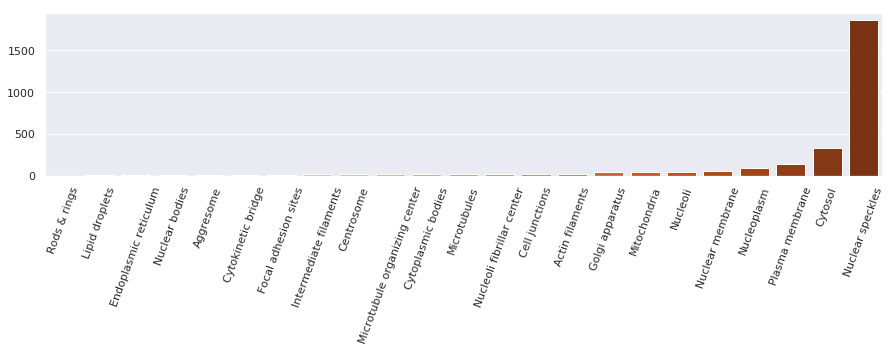

In [17]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

In [18]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [19]:
path_to_train = '../input/train/'
data = pd.read_csv('../input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [20]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        image_red_ch = skimage.io.imread(path+'_red.png')
        image_yellow_ch = skimage.io.imread(path+'_yellow.png')
        image_green_ch = skimage.io.imread(path+'_green.png')
        image_blue_ch = skimage.io.imread(path+'_blue.png')

        image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
        image_green_ch += (image_yellow_ch/2).astype(np.uint8)

        image = np.stack((
            image_red_ch, 
            image_green_ch, 
            image_blue_ch), -1)
        image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image
    
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [21]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 1.0


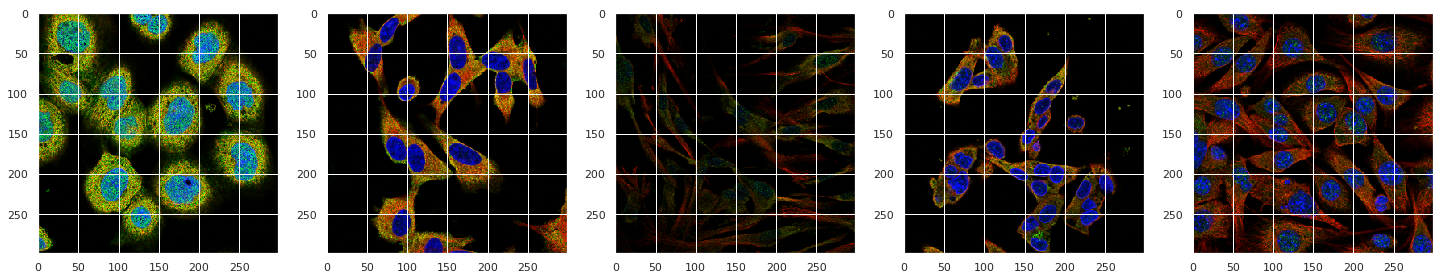

In [22]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))


**CREATE MODEL**

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)
    
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

Using TensorFlow backend.


In [24]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc'])

model.summary()

219062272/219055592 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
activation_205 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2

**Train model**

In [25]:
epochs = 50; batch_size = 16
checkpointer = ModelCheckpoint(
    '../working/InceptionResNetV2.model', 
    verbose=2, 
    save_best_only=True)

# split and suffle data 
np.random.seed(2018)
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes = indexes[:27500]
valid_indexes = indexes[27500:]

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (299,299,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 100, (299,299,3), augument=False)

# train model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/50
50/50 [==============================] - 160s 3s/step - loss: 5.2756 - acc: 0.4100 - val_loss: 4.8859 - val_acc: 0.4200

Epoch 00001: val_loss improved from inf to 4.88592, saving model to ../working/InceptionResNetV2.model
Epoch 2/50
50/50 [==============================] - 93s 2s/step - loss: 5.0428 - acc: 0.3612 - val_loss: 5.0049 - val_acc: 0.4200

Epoch 00002: val_loss did not improve from 4.88592
Epoch 3/50
50/50 [==============================] - 92s 2s/step - loss: 4.9335 - acc: 0.3112 - val_loss: 4.7997 - val_acc: 0.4200

Epoch 00003: val_loss improved from 4.88592 to 4.79967, saving model to ../working/InceptionResNetV2.model
Epoch 4/50
50/50 [==============================] - 93s 2s/step - loss: 4.9673 - acc: 0.2525 - val_loss: 4.7145 - val_acc: 0.4200

Epoch 00004: val_loss improved from 4.79967 to 4.71453, saving model to ../working/InceptionResNetV2.model
Epoch 5/50
50/50 [==============================] - 92s 2s/step - loss: 4.9689 - acc: 0.2775 - val_loss: 6.

50/50 [==============================] - 92s 2s/step - loss: 4.1799 - acc: 0.3925 - val_loss: 3.5982 - val_acc: 0.4300

Epoch 00043: val_loss improved from 3.79989 to 3.59819, saving model to ../working/InceptionResNetV2.model
Epoch 44/50
50/50 [==============================] - 93s 2s/step - loss: 4.0830 - acc: 0.4425 - val_loss: 3.6070 - val_acc: 0.4200

Epoch 00044: val_loss did not improve from 3.59819
Epoch 45/50
50/50 [==============================] - 92s 2s/step - loss: 4.1089 - acc: 0.4225 - val_loss: 3.6550 - val_acc: 0.4300

Epoch 00045: val_loss did not improve from 3.59819
Epoch 46/50
50/50 [==============================] - 92s 2s/step - loss: 4.0255 - acc: 0.3962 - val_loss: 3.6457 - val_acc: 0.4300

Epoch 00046: val_loss did not improve from 3.59819
Epoch 47/50
50/50 [==============================] - 92s 2s/step - loss: 4.0765 - acc: 0.4225 - val_loss: 3.6719 - val_acc: 0.4300

Epoch 00047: val_loss did not improve from 3.59819
Epoch 48/50
50/50 [======================

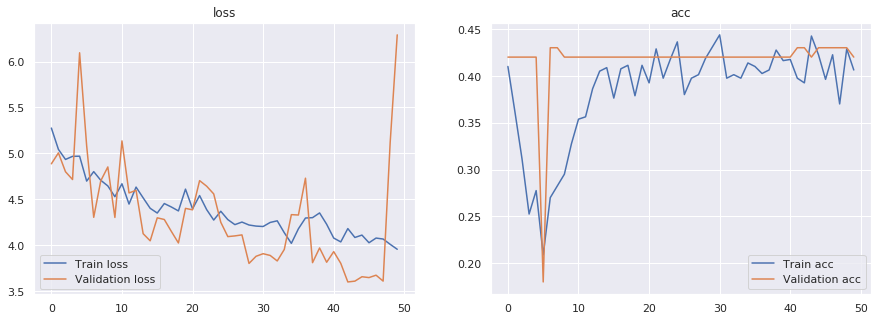

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()